## DS 410 Final Project

Importing libraries, Creating Spark Session, and Reading in the Dataset

In [2]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.functions import lower
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
from pyspark.sql.functions import col, column
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql import Row
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import sparknlp

from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, ArrayType
from nltk.stem.porter import PorterStemmer
import nltk



# Download NLTK data
nltk.download('punkt', quiet=True)


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 744 kB 5.4 MB/s eta 0:00:01


True

In [3]:
ss=SparkSession.builder.master("local").appName("Final_Project").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/18 14:35:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
ss.sparkContext.setCheckpointDir("~/scratch")

In [5]:
schema = StructType([StructField("Sentiment", IntegerType(), nullable = False), \
                     StructField("Title", StringType(), nullable = False), \
                     StructField("Text", StringType(), nullable = False)
                    ])

In [6]:
reviews1 = ss.read.csv("Amazon_reviews_sample.csv", schema = schema, header = True, inferSchema = False)

In [7]:
reviews = reviews1.na.drop()

In [8]:
reviews.printSchema()

root
 |-- Sentiment: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Text: string (nullable = true)



In [9]:
reviews.show(5)

+---------+--------------------+--------------------+
|Sentiment|               Title|                Text|
+---------+--------------------+--------------------+
|        1|Sorry I wasted my...|Neil Gaiman wrote...|
|        1|Loved the prose, ...|Rabbit was not a ...|
|        2|         FASCINATING|Am a Jack Higgins...|
|        1|Little Annie Fann...|This was very, ve...|
|        2|     pressing matter|I have owned Rowe...|
+---------+--------------------+--------------------+
only showing top 5 rows


## EDA

## Distribution of Review Sentiment

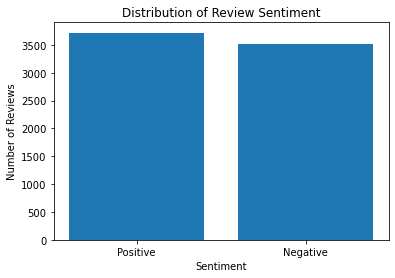

In [10]:
reviews_label = reviews.withColumn("Labeled Sentiment", when(reviews["Sentiment"] == 2, "Positive").when(reviews["Sentiment"] == 1, "Negative"))
sentiment_counts = reviews_label.groupBy("Labeled Sentiment").count()
pandas_sentiment=sentiment_counts.toPandas()
plt.bar(pandas_sentiment["Labeled Sentiment"],pandas_sentiment["count"])
plt.title("Distribution of Review Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

Removing special characters

In [11]:
from pyspark.sql.functions import regexp_replace
reviews_special_title = reviews_label.withColumn("Title", regexp_replace("Title", "[^a-zA-Z0-9\\s]", ""))
reviews_only_text = reviews_special_title.withColumn("Text", regexp_replace("Text", "[^a-zA-Z0-9\\s]", ""))

Making all words lowercase and splitting by space

In [12]:
reviews_split_title = reviews_label.withColumn("Title", split(lower(reviews_label["Title"]), " "))
reviews_split_title_text = reviews_split_title.withColumn("Text", split(lower(reviews_split_title["Text"]), " "))

Removing stop words, making rdd of title of reviews and text of reviews for positive and negative sentiment

In [13]:
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCols=["Title", "Text"], outputCols=["Title (No Stop Words)", "Text (No Stop Words)"])
reviews_no_stop_words = remover.transform(reviews_split_title_text)
reviews_title_flat_pos = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Positive").select("Title (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)
reviews_text_flat_pos = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Positive").select("Text (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)
reviews_title_flat_neg = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Negative").select("Title (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)
reviews_text_flat_neg = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Negative").select("Text (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)

Concatenate title and reviews rdd for positive and negative sentiment

In [14]:
reviews_pos = reviews_title_flat_pos.union(reviews_text_flat_pos)
reviews_neg = reviews_title_flat_neg.union(reviews_text_flat_neg)

Map words to key-value pairs ex. (word, 1)

In [15]:
reviews_pos_key_val = reviews_pos.map(lambda x: (x, 1))
reviews_neg_key_val = reviews_neg.map(lambda x: (x, 1))

Reduce key-value pairs by key (aggregate counts of words)

In [16]:
reviews_pos_key_val_reduced = reviews_pos_key_val.reduceByKey(lambda x, y: x + y, 4)
reviews_neg_key_val_reduced = reviews_neg_key_val.reduceByKey(lambda x, y: x + y, 4)

Sort aggregated counts of words in descending order

In [17]:
reviews_pos_key_val_sorted = reviews_pos_key_val_reduced.sortBy(lambda pair: pair[1], ascending=False)
reviews_neg_key_val_sorted = reviews_neg_key_val_reduced.sortBy(lambda pair: pair[1], ascending=False)

Get ten most frequent words for title of reviews and text of reviews

In [18]:
reviews_pos_key_val_sorted_top_ten = reviews_pos_key_val_sorted.take(10)
reviews_neg_key_val_sorted_top_ten  = reviews_neg_key_val_sorted.take(10)

## Bar graph of ten most frequent words in positive reviews

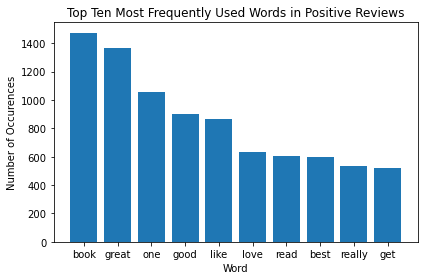

In [19]:
plt.bar([item[0] for item in reviews_pos_key_val_sorted_top_ten], [item[1] for item in reviews_pos_key_val_sorted_top_ten])
plt.xlabel("Word")
plt.ylabel("Number of Occurences")
plt.title("Top Ten Most Frequently Used Words in Positive Reviews")
plt.tight_layout()
plt.show()

## Bar graph of ten most frequent words in negative reviews

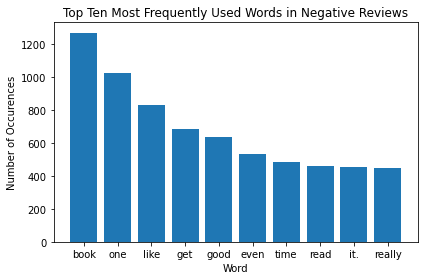

In [20]:
plt.bar([item[0] for item in reviews_neg_key_val_sorted_top_ten], [item[1] for item in reviews_neg_key_val_sorted_top_ten])
plt.xlabel("Word")
plt.ylabel("Number of Occurences")
plt.title("Top Ten Most Frequently Used Words in Negative Reviews")
plt.tight_layout()
plt.show()

# PreProcessing Data

### Add Stemming
Stemming reduces words to their root form (e.g., "running" -> "run", "playing" -> "play"

Remove punctuation from each word and apply Porter Stemmer. (Porter Stemmer is a process of removing suffixes of words in five steps, reducing them to their root form, as degined above!)
    
Example:
- Input:  ['sorry', 'wasted', 'time.', 'book!']
- Output: ['sorri', 'wast', 'time', 'book']

Import Libraries Needed for Stemming

In [21]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, ArrayType
from nltk.stem.porter import PorterStemmer
import nltk
import re

# Download NLTK data (run once)
try:
    nltk.download('punkt', quiet=True)
    #print("✓ NLTK data downloaded")
except:
    print("NLTK data already available")


In [22]:
def clean_and_stem_words(words):
    #Remove punctuation from each word and apply Porter Stemmer
    
    if words is None:
        return []
    
    stemmer = PorterStemmer()
    cleaned_stemmed = []
    
    for word in words:
        # Remove all non-alphabetic characters (punctuation, numbers, symbols)
        clean_word = re.sub(r'[^a-zA-Z]', '', word)
        
        # Only process if something remains after cleaning
        if clean_word:
            # Apply stemming
            stemmed = stemmer.stem(clean_word.lower())
            cleaned_stemmed.append(stemmed)
    
    return cleaned_stemmed

#Spark UDF
clean_stem_udf = udf(clean_and_stem_words, ArrayType(StringType()))

#print("✓ Stemming function created (with punctuation removal)!")


### Apply stemming function to Reviews given

In [23]:
# Columns are named "Title (No Stop Words)" and "Text (No Stop Words)"
# with spaces and parentheses, use backticks to reference columns with spaces
# we apply the clean stemming function to these cells 

# Apply to both columns
reviews_stemmed = reviews_no_stop_words.withColumn(
    "Title_Stemmed",
    clean_stem_udf(col("`Title (No Stop Words)`"))
).withColumn(
    "Text_Stemmed",
    clean_stem_udf(col("`Text (No Stop Words)`"))
)

#print(f"Stemming Total records: {reviews_stemmed.count():,}")

# Show example of the transformation
#print("\n" + "="*70)
#print("EXAMPLE: Before vs After Cleaning + Stemming")
#print("="*70)


# sample = reviews_stemmed.select(
#     "`Title (No Stop Words)`", 
#     "Title_Stemmed",
#     "`Text (No Stop Words)`", 
#     "Text_Stemmed"
# ).first()

# print("\n📝 TITLE:")
# print(f"  Before: {sample['Title (No Stop Words)'][:5]}")
# print(f"  After:  {sample['Title_Stemmed'][:5]}")

# print("\n📝 TEXT:")
# print(f"  Before: {sample['Text (No Stop Words)'][:5]}")
# print(f"  After:  {sample['Text_Stemmed'][:5]}")

# print("\n✓ Punctuation removed and words stemmed!")
# print("="*70)


### Preparing Data for Hugging Face

Formatting to be used by transformers

In [24]:
from pyspark.sql.functions import concat_ws, array_join, when

# Combine stemmed title + text into one column for transformers that can be used for model output
# Create binary labels (0=Negative, 1=Positive) used by Hugging Face. 

reviews_for_transformers = reviews_stemmed.withColumn(
    "text",  # Column name expected by Hugging Face
    concat_ws(" ", 
              array_join(col("Title_Stemmed"), " "),
              array_join(col("Text_Stemmed"), " "))
).withColumn(
    "label",  # Binary label: 0=Negative, 1=Positive
    when(col("Sentiment") == 2, 1).otherwise(0)
).select("text", "label", "Sentiment", "Labeled Sentiment")

#print("Data prepared for Hugging Face transformers!")
#print("\n" + "="*70)
#print("Sample of Transformer-Ready Data:")
#print("="*70)
#reviews_for_transformers.show(3, truncate=70, vertical=False)

#print("\nData format:")
#print("  • text:   Combined, cleaned, stemmed review text")
#print("  • label:  Binary (0=Negative, 1=Positive)")
#print("  • Ready for BERT, RoBERTa, DistilBERT, etc.")


## Creating Test Train Split
Split data: 60% training, 20% validation, 20% testing
- Validation is used for hyperparameter tuning
- Test is used for final model evaluation
- Use seed for reproducibility

In [25]:
# Split data: 60% training, 20% testing, 20% validation
# Use seed for reproducibility
train_data, valid_data, test_data = reviews_for_transformers.randomSplit([0.6, 0.2, 0.2], seed=42)

# Cache all three sets for faster access during modeling
train_data.cache()
valid_data.cache()
test_data.cache()


# Count records (forces computation and caching)
train_count = train_data.count()
valid_count = valid_data.count()
test_count = test_data.count()
total_count = train_count + valid_count + test_count


# print("Data split complete!")
# print("\n" + "="*70)
# print("Dataset Statistics:")
# print("="*70)
# print(f"  Training set: {train_count:,} records ({100*train_count/total_count:.1f}%)")
# print(f"  Test set:     {test_count:,} records ({100*test_count/total_count:.1f}%)")
# print(f"  Total:        {total_count:,} records")

# # Check label distribution in both sets
# print("\n" + "="*70)
# print("Label Distribution:")
# print("="*70)

# print("\n📊 Training Set:")
# train_label_dist = train_data.groupBy("label", "Labeled Sentiment").count().orderBy("label")
# train_label_dist.show()

# print("📊 Test Set:")
# test_label_dist = test_data.groupBy("label", "Labeled Sentiment").count().orderBy("label")
# test_label_dist.show()

# # Check if balanced
# train_labels = train_data.groupBy("label").count().collect()
# balance_ratio = min(train_labels[0]['count'], train_labels[1]['count']) / max(train_labels[0]['count'], train_labels[1]['count'])
# print(f"Class balance: {balance_ratio:.2%} ({'Balanced' if balance_ratio > 0.9 else 'Slightly imbalanced'})")



print(f"Split Complete:")
print(f"  Training:   {train_count:,} ({train_count/(train_count+valid_count+test_count)*100:.1f}%)")
print(f"  Validation: {valid_count:,} ({valid_count/(train_count+valid_count+test_count)*100:.1f}%)")
print(f"  Test:       {test_count:,} ({test_count/(train_count+valid_count+test_count)*100:.1f}%)")


Split Complete:
  Training:   4,449 (61.5%)
  Validation: 1,403 (19.4%)
  Test:       1,378 (19.1%)


## Saving Preprocessed Data

This step saves the cleaned and split datasets (train, validation, test) to disk in Parquet format so they can be reloaded later without rerunning preprocessing. Each dataset is written to its own folder for efficient access during model training.

Key points:

- Stores final data in /preprocessed_data_sample directory
- Uses mode("overwrite") to replace old files
- Parquet format = fast, compressed, and Spark-friendly
- Makes results reproducible and ready for transformer models

In [26]:
# Set output path 
OUTPUT_PATH = "preprocessed_data_sample"

# print("="*70)
# print("Saving Preprocessed Data...")
# print("="*70)

# # Save training data
# print(f"\nSaving training data...")
# train_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/train_transformer_ready")
# print(f"   Saved to: {OUTPUT_PATH}/train_transformer_ready/")

# # Save validation data (NEW!)
# print(f"\nSaving validation data...")
# valid_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/valid_transformer_ready")
# print(f"   Saved to: {OUTPUT_PATH}/valid_transformer_ready/")

# # Save test data
# print(f"\nSaving test data...")
# test_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/test_transformer_ready")
# print(f"   Saved to: {OUTPUT_PATH}/test_transformer_ready/")

# # Save full stemmed dataset (includes all columns for reference)
# print(f"\nSaving full stemmed dataset...")
# reviews_stemmed.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/reviews_stemmed")
# print(f"   Saved to: {OUTPUT_PATH}/reviews_stemmed/")

# print("\n" + "="*70)
# print("All data saved successfully!")
# print("="*70)
# print(f"\nModeling team can load with:")
# print(f'  train_df = spark.read.parquet("{OUTPUT_PATH}/train_transformer_ready")')
# print(f'  valid_df = spark.read.parquet("{OUTPUT_PATH}/valid_transformer_ready")')
# print(f'  test_df = spark.read.parquet("{OUTPUT_PATH}/test_transformer_ready")')



print("Saving data: ")

train_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/train_transformer_ready")
print(f" Training saved")

valid_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/valid_transformer_ready")
print(f" Validation saved")

test_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/test_transformer_ready")
print(f" Test saved")

# Free up memory
train_data.unpersist()
valid_data.unpersist()
test_data.unpersist()

print("All data saved and memory freed!")
print(f"\nModeling team can load with:")
print(f'  spark.read.parquet("{OUTPUT_PATH}/train_transformer_ready")')
print(f'  spark.read.parquet("{OUTPUT_PATH}/valid_transformer_ready")')
print(f'  spark.read.parquet("{OUTPUT_PATH}/test_transformer_ready")')



Saving data: 


 Training saved
 Validation saved
 Test saved
All data saved and memory freed!

Modeling team can load with:
  spark.read.parquet("preprocessed_data_sample/train_transformer_ready")
  spark.read.parquet("preprocessed_data_sample/valid_transformer_ready")
  spark.read.parquet("preprocessed_data_sample/test_transformer_ready")


## Spark imports for SVM

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## Read in data

In [28]:
train_df = ss.read.parquet("preprocessed_data_sample/train_transformer_ready")
valid_df = ss.read.parquet("preprocessed_data_sample/valid_transformer_ready")
test_df  = ss.read.parquet("preprocessed_data_sample/test_transformer_ready")

## Tokenizing & tf/idf and casting to doubles

In [29]:
# Cast label in ALL splits (SVM expects double)
train_df = train_df.withColumn("label", col("label").cast("double"))
valid_df = valid_df.withColumn("label", col("label").cast("double"))
test_df  = test_df.withColumn("label",  col("label").cast("double"))
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
tf        = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=100_000)
idf       = IDF(inputCol="rawFeatures", outputCol="features")

## SVM

In [30]:
svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=100, regParam=0.1)
pipeline = Pipeline(stages=[tokenizer, tf, idf, svm])
# Ignore warnings it runs fine
model = pipeline.fit(train_df)

25/11/18 14:37:42 WARN DAGScheduler: Broadcasting large task binary with size 1630.3 KiB
25/11/18 14:37:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/11/18 14:37:43 WARN DAGScheduler: Broadcasting large task binary with size 1630.9 KiB
25/11/18 14:37:43 WARN DAGScheduler: Broadcasting large task binary with size 1630.9 KiB
25/11/18 14:37:43 WARN DAGScheduler: Broadcasting large task binary with size 1630.9 KiB
25/11/18 14:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1630.9 KiB
25/11/18 14:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1630.9 KiB
25/11/18 14:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1630.9 KiB
25/11/18 14:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1630.9 KiB
25/11/18 14:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1630.9 KiB
25/11/18 14:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1630.9 KiB
25/

## Accuracy Metrics

In [32]:
evaluator_f1  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

valid_pred = model.transform(valid_df)

print("Validation — F1:", evaluator_f1.evaluate(valid_pred), "| Accuracy:", evaluator_acc.evaluate(valid_pred))

25/11/18 14:38:20 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/11/18 14:38:20 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


Validation — F1: 0.8244929658116956 | Accuracy: 0.8246614397719173


## XGBOOST

In [33]:
train_df = ss.read.parquet("preprocessed_data_sample/train_transformer_ready")
valid_df = ss.read.parquet("preprocessed_data_sample/valid_transformer_ready")
test_df  = ss.read.parquet("preprocessed_data_sample/test_transformer_ready")

for name in ("train_df","valid_df","test_df"):
    locals()[name] = locals()[name].withColumn("label", col("label").cast("double"))

tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
tf  = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=50_000)  # ↓ from 200k
idf = IDF(inputCol="rawFeatures", outputCol="features")

featurizer = Pipeline(stages=[tokenizer, tf, idf]).fit(train_df)
train_f = featurizer.transform(train_df).select("features", "label").repartition(1).cache()
valid_f = featurizer.transform(valid_df).select("features", "label").repartition(1).cache()
test_f  = featurizer.transform(test_df).select("features", "label").repartition(1).cache()



## XGBOOST Training

In [34]:
from xgboost.spark import SparkXGBClassifier

pos = train_f.filter(col("label") == 1.0).count()
neg = train_f.filter(col("label") == 0.0).count()
scale_pos_weight = float(neg) / max(float(pos), 1.0)


xgb = SparkXGBClassifier(
    features_col="features",
    label_col="label",
    prediction_col="prediction",
    probability_col="probability",
    raw_prediction_col="rawPrediction",
    num_workers=1,            
    tree_method="hist",
    eval_metric="aucpr",          
    max_depth=6,
    eta=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight
)

xgb_model = xgb.fit(train_f)

2025-11-18 14:38:32,287 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'eval_metric': 'aucpr', 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'scale_pos_weight': 0.9419467481449149, 'subsample': 0.8, 'tree_method': 'hist', 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
/storage/home/msn5265/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/storage/home/msn5265/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
2025-11-18 14:38

## XGBoost accuracy metrics

In [35]:
valid_pred = xgb_model.transform(valid_f).cache()
test_pred  = xgb_model.transform(test_f).cache()

e_aucpr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
e_auc   = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
e_f1    = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
e_acc   = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

print("Validation — AUC-PR:", e_aucpr.evaluate(valid_pred),
      "| AUC-ROC:", e_auc.evaluate(valid_pred),
      "| F1:", e_f1.evaluate(valid_pred),
      "| Acc:", e_acc.evaluate(valid_pred))

/storage/home/msn5265/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/storage/home/msn5265/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
2025-11-18 14:41:29,705 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Validation — AUC-PR: 0.886422232965031 | AUC-ROC: 0.8894759310456969 | F1: 0.7982690896895781 | Acc: 0.7982893799002139


In [36]:
from pyspark.sql.functions import col
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


train_df = train_df.withColumn("label", col("label").cast("double"))
valid_df = valid_df.withColumn("label", col("label").cast("double"))
test_df  = test_df.withColumn("label",  col("label").cast("double"))


tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
tf        = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=100_000)
idf       = IDF(inputCol="rawFeatures", outputCol="features")

In [37]:
# Decision Tree model 
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=10)

# Full pipeline 
pipeline = Pipeline(stages=[tokenizer, tf, idf, dt])

# Fit and evaluate 
model = pipeline.fit(train_df)

25/11/18 14:41:44 WARN DAGScheduler: Broadcasting large task binary with size 1629.4 KiB
25/11/18 14:41:44 WARN DAGScheduler: Broadcasting large task binary with size 1629.3 KiB
25/11/18 14:41:44 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/11/18 14:42:16 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/11/18 14:42:17 WARN MemoryStore: Not enough space to cache rdd_588_0 in memory! (computed 362.8 MiB so far)
25/11/18 14:42:17 WARN BlockManager: Persisting block rdd_588_0 to disk instead.
25/11/18 14:42:24 WARN MemoryStore: Not enough space to cache rdd_588_0 in memory! (computed 362.8 MiB so far)
25/11/18 14:42:27 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/11/18 14:42:27 WARN MemoryStore: Not enough space to cache rdd_588_0 in memory! (computed 362.8 MiB so far)
25/11/18 14:42:30 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/11/18 14:42:31 WARN MemoryStore: Not enough space to cache rd

## Predictions and Accuracy

## RANDOM FOREST

In [38]:
train_df = ss.read.parquet("preprocessed_data_sample/train_transformer_ready")
valid_df = ss.read.parquet("preprocessed_data_sample/valid_transformer_ready")
test_df  = ss.read.parquet("preprocessed_data_sample/test_transformer_ready")

In [39]:
from pyspark.sql.functions import col
from pyspark.ml.feature import Tokenizer, HashingTF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make sure label is double
train_df = train_df.withColumn("label", col("label").cast("double"))
valid_df = valid_df.withColumn("label", col("label").cast("double"))

# Text preprocessing
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
tf = HashingTF(inputCol="tokens", outputCol="features", numFeatures=100000)

# Random Forest model
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=50,        # you can tune this
    maxDepth=5,         # you can tune this
    featureSubsetStrategy="auto",
)

# Pipeline
pipeline = Pipeline(stages=[tokenizer, tf, rf])

# Train on train_df
rf_model = pipeline.fit(train_df)


25/11/18 14:44:19 WARN DAGScheduler: Broadcasting large task binary with size 1041.7 KiB
25/11/18 14:44:51 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/11/18 14:44:52 WARN MemoryStore: Not enough space to cache rdd_653_0 in memory! (computed 363.0 MiB so far)
25/11/18 14:44:52 WARN BlockManager: Persisting block rdd_653_0 to disk instead.
25/11/18 14:44:59 WARN MemoryStore: Not enough space to cache rdd_653_0 in memory! (computed 363.0 MiB so far)
25/11/18 14:45:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/18 14:45:03 WARN MemoryStore: Not enough space to cache rdd_653_0 in memory! (computed 363.0 MiB so far)
25/11/18 14:45:07 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/18 14:45:07 WARN MemoryStore: Not enough space to cache rdd_653_0 in memory! (computed 363.0 MiB so far)
25/11/18 14:45:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/11/18 14:45:12 WARN MemoryStore: Not en

In [40]:
# Predict ONLY on validation set
valid_pred = rf_model.transform(valid_df)

## Predictions and Accuracy

In [41]:
# Evaluate validation accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

print("Validation Accuracy:", evaluator.evaluate(valid_pred))

Validation Accuracy: 0.6486101211689237


# NaiveBayes

In [42]:
train_df = ss.read.parquet("preprocessed_data_sample/train_transformer_ready")
valid_df = ss.read.parquet("preprocessed_data_sample/valid_transformer_ready")
test_df  = ss.read.parquet("preprocessed_data_sample/test_transformer_ready")

In [43]:
from pyspark.sql.functions import col
from pyspark.ml.feature import Tokenizer, HashingTF
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Ensure label is double (Spark requirement)
train_df = train_df.withColumn("label", col("label").cast("double"))
valid_df = valid_df.withColumn("label", col("label").cast("double"))
test_df  = test_df.withColumn("label", col("label").cast("double"))

# Text → tokens
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")

# Tokens → raw term counts
tf = HashingTF(
    inputCol="tokens",
    outputCol="features",
    numFeatures=100000   # You can increase if you want more expressive features
)

# Naive Bayes (multinomial = best for count data)
nb = NaiveBayes(
    labelCol="label",
    featuresCol="features",
    modelType="multinomial",
    smoothing=1.0  # default Laplace smoothing
)

# Full pipeline
pipeline = Pipeline(stages=[tokenizer, tf, nb])

# Train model
nb_model = pipeline.fit(train_df)

In [44]:
# Predict on validation + test
valid_pred = nb_model.transform(valid_df)
test_pred  = nb_model.transform(test_df)

In [45]:
# Make predictions on validation and test sets
valid_pred = nb_model.transform(valid_df)


# Evaluate model accuracy on validation and test sets
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

valid_accuracy = evaluator.evaluate(valid_pred)


print("Validation Accuracy:", valid_accuracy)


Validation Accuracy: 0.8132573057733429


25/11/18 14:47:29 WARN DAGScheduler: Broadcasting large task binary with size 1633.4 KiB
